In this programming exercise you will train a model to perform N-way, K-shot classification on the Omniglot dataset which consists of 1623 characters from 50 different languages, where each character has 20 28x28 images.

# Data Setup

Download and unzip the Omniglot data. Run the following commands in the directory with this file:

```
git clone https://github.com/brendenlake/omniglot.git
ln -s omniglot/python data
cd data
unzip images_background.zip
unzip images_evaluation.zip
cd ..
```

You may use a GPU for faster training.


In [1]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from glob import glob
from skimage import io, transform

# Global Constants

In this exercise we will only be tackling the 5-way 1-shot classification setting in Omniglot. Hence, $N = 5$ and $K = Q = 1$.

In [3]:
# Global parameters
H, W = 28, 28    # Images will be resized to this height and width
N_way = 5 # Number of ways
K_shot = Q_queryperclass = 1 # K_shot is the number of shots

# Data loading parameters only
num_writers = 20    # Number of drawings per character
num_alphabets = 50   # Number of alphabets in Omniglot (explained below)
num_characters = 1623 # Number of characters in the entire Omniglot

# Data

You are provided code for loading image data from the Omniglot directories into this program. The data is grouped by alphabets; for each alphabet $A_i$, we consolidate the images into a shape `(num_Ai, num_writers, H, W)` array, where `num_Ai` is the number of characters in $A_i$. In general, each alphabet has around 20 to 50 characters. We save the arrays into `./cache/dataset.npy` so that loading the data is faster the next time we run the program.

In [4]:
# Define path constants
root = 'drive/MyDrive/Exercise 8/'
data_path = os.path.join(root, 'data')
cache_path = os.path.join(root, 'cache')
os.makedirs(cache_path, exist_ok=True)
dataset_path = os.path.join(cache_path, 'dataset.npy')

if os.path.exists(dataset_path): # We've consolidated the data before, just load it in
    alphabets = np.load(dataset_path, allow_pickle=True).item()
else: 
    # We need to consolidate the data from individual images to numpy arrays
    # The "background" set is the training set and the "evaluation" set is the test set in the
    # original Omniglot paper. However, few-shot learning papers have just combined them into one set
    # then split their own training and test sets, so we will do that too.
    image_paths = glob(os.path.join(data_path, 'images_background/*/*/*.png'))
    image_paths.extend(glob(os.path.join(data_path, 'images_evaluation/*/*/*.png')))
    print('Example path', image_paths[0])

    image_paths = sorted(image_paths)
    alphabets = defaultdict(list)
    for image_path in image_paths:
        *_, alphabet, character, drawing = image_path.split('/')
        # Here we load in images and resize all images to H by W with skimage
        alphabets[alphabet].append(transform.resize(io.imread(image_path), [H, W]))
    
    # Omniglot, with 1623 total classes, is actually divided into 50 variable-sized alphabets
    alphabets = {alphabet: np.stack(images).reshape(-1, num_writers, H, W) for alphabet, images in alphabets.items()}
    np.save(dataset_path, alphabets)

We first preprocess the meta-dataset. We then split the meta-dataset `alphabets` into training, validation, and test splits. The split sizes are roughly what few-shot learning papers typically use.

In [5]:
# Normally it's good to center and normalize data, but here since each image's white background
# has greyscale value 1.0 and the black writing has 0.0, we simply do 1 - the image to make most of the image
# 0.0 and the writing 1.0
processed_alphabets = {n: 1 - alphabet for n, alphabet in alphabets.items()}

# Here we split 25% alphabets into the validation and test meta-datasets, each.
# This is actually not what most of the papers do; they usually directly split the 1623 characters instead
# of alphabets
rng = np.random.RandomState(0)
alphabet_names = list(alphabets)
rng.shuffle(alphabet_names) # randomize the alphabets 
num_train, num_val = int(num_alphabets * 0.5), int(num_alphabets * 0.25)

# Train, val, test sets
train_val_test_splits = np.split(alphabet_names, [num_train, num_train + num_val])
sets = [{n: processed_alphabets[n] for n in names} for names in train_val_test_splits]
train_alphabets, val_alphabets, test_alphabets = sets
print('Number of alphabets in train, validation, test:', [len(x) for x in sets])
print('Number of characters in train, validation, test:', [sum(len(v) for v in x.values()) for x in sets])

Number of alphabets in train, validation, test: [25, 12, 13]
Number of characters in train, validation, test: [789, 381, 453]


Here we visualize the characters in the alphabet by sampling 10 random alphabets and one random character per alphabet. Each row is a different character and each column is a different writer (20 writers total).

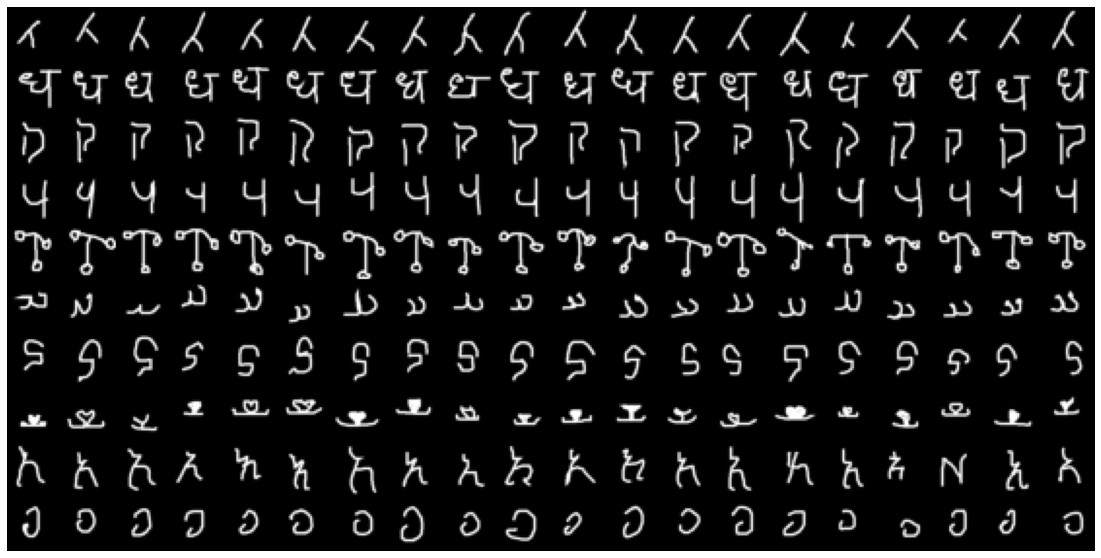

In order from top to bottom, the characters above are:
Tifinagh alphabet, character 19
Sanskrit alphabet, character 18
Hebrew alphabet, character 18
Asomtavruli_(Georgian) alphabet, character 21
Angelic alphabet, character 14
Avesta alphabet, character 18
Mongolian alphabet, character 8
Syriac_(Estrangelo) alphabet, character 21
Ge_ez alphabet, character 12
Tagalog alphabet, character 15


In [6]:
plt.figure(figsize=(20, 10))
imgs = []
classes = []
for alphabet_name in np.random.choice(list(train_alphabets), size=10):
    alphabet = train_alphabets[alphabet_name]
    char_index = np.random.randint(len(alphabet))
    imgs.append(np.concatenate(alphabet[char_index], axis=1))
    classes.append((alphabet_name, char_index))
plt.imshow(np.concatenate(imgs, axis=0), cmap='gray')
plt.axis('off')
plt.show()
print('In order from top to bottom, the characters above are:')
print('\n'.join(f'{a} alphabet, character {c}' for a, c in classes))

# Task Loader for Sampling Tasks

We now look at the `MixAlphabetsDataLoader` for few-shot classification. Note that `augment_rotate` and `augment_flip` are used in many few-shot learning papers to increase the amount of training data by rotating and flipping the characters in the training set and treating the rotated and flipped versions like new characters. In other words, if our alphabet has $C$ characters total, after rotating and flipping our alphabet will end up with $8C$ characters.

In [7]:
class MixAlphabetsTaskLoader:
    def __init__(self, alphabets, batch_size, augment_rotate=False, augment_flip=False):
        """
        Since most few-shot learning papers just mix the alphabets together when sampling characters for tasks,
        we just concatenate the characters in different alphabets together here

        alphabets: a dictionary mapping from alphabet names to numpy arrays of size
            (num_characters, num_writers, H, W), where num_characters is the number of characters in the alphabet
        batch_size: number of tasks to generate at once
        augment_rotate: whether to augment the data by rotating each alphabet 0, 90, 180, and 270 degrees
        augment_flip: whether to augment the data by flipping each alphabet horizontally
        """
        self.batch_size = batch_size
        self.data = np.concatenate(list(alphabets.values())) # shape (num_class, num_writers, H, W)
        if augment_rotate:
            self.data = np.concatenate([np.rot90(self.data, k=k, axes=(2, 3)) for k in range(4)])
        if augment_flip:
            self.data = np.concatenate([self.data, self.data[:, :, :, ::-1]])
    
    def __iter__(self):
        """
        This class is an iterable that yields a batch of tasks at each iteration when used in a for-loop.
        Each task in the batch has N_way classes (characters) randomly sampled from the meta-dataset.
        Each class has K_shot + Q_queryperclass images; the first K_shot images are the support set 
        and the last Q_queryperclass images are the queries

        return: a batch of tasks, which should be a numpy array shaped
            (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        """
        num_class = len(self.data)
        while True:
            batch = []
            for _ in range(self.batch_size):
                classes = np.random.choice(num_class, size=N_way, replace=False)
                supports_queries = [] # Shape (K_shot + Q_queryperclass, H, W)
                for cls in classes:
                    idxs = np.random.choice(num_writers, size=K_shot + Q_queryperclass, replace=False)
                    supports_queries.append(self.data[cls, idxs])
                batch.append(supports_queries)
                
            yield np.array(batch) # Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)

In [8]:
# We use a batch size of 64 while training
train_metadataset = MixAlphabetsTaskLoader(train_alphabets, 64, augment_rotate=True, augment_flip=True)
# We can use a batch size of 1600 for validation or testing
val_metadataset = MixAlphabetsTaskLoader(val_alphabets, 1600)
test_metadataset = MixAlphabetsTaskLoader(test_alphabets, 1600)

# Few-shot Algorithms

Finally, it's your time to do some coding. For this part, you will complete a given implementation of one-shot learning methods described in these papers: [Matching Network](https://arxiv.org/pdf/1606.04080.pdf) and [Prototypical Network](https://arxiv.org/abs/1703.05175). We'll implement the `BaseNetwork` base class which is shared between `MatchingNetwork` and `PrototypicalNetwork`, but you're welcome to put nothing in the `BaseNetwork` if you don't like subclassing. Note that for this entire assignment we are assuming $K = Q = 1$, and you may use that to make your implementation easier.

In general, you should only modify the part of the code with `### Your code here ###`.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Feel free to change for those with GPUs

def conv_block(in_depth, out_depth, pool_size=2):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_depth, out_channels=out_depth, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_depth),
        nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
    )

class BaseNetwork(nn.Module):
    def __init__(self, depth=64):
        """
        Base network for MatchingNetwork and PrototypicalNetwork. The base network should
        define the four convolution blocks in the backbone of the methods.
        """
        super().__init__()
        ### Your code here ###
        
        self.depth = depth
        self.encoder = nn.Sequential(
            conv_block(1, depth, pool_size = 2),
            conv_block(depth, depth, pool_size = 2),
            conv_block(depth, depth, pool_size = 2),
            conv_block(depth, depth, pool_size = 2)
        )
        
    
    def forward(self, tasks, labels):
        """
        Forward pass of the neural network
        
        tasks: a torch Float tensor of a batch of tasks.
            Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        labels: a torch Long tensor of labels corresponding to tasks.
            Shape (batch_size, N_way)
        
        return: a tuple (loss, accuracy) of two torch Float scalars representing the mean loss and
            mean accuracy of the batch
        """
        ### Your code here ###
        batch_size, n_way, kq_num, H, W = tasks.shape
        tasks = torch.Tensor(tasks)

        support = tasks[:,:,0:kq_num-1,:,:].contiguous().view(batch_size * n_way * (kq_num - 1), -1, H, W).to(device) 
        queries = tasks[:,:,-1,:,:].view(batch_size * n_way, -1, H, W).to(device)

        encoded_support = self.encoder(support).view(batch_size * n_way, -1) 
        encoded_queries = self.encoder(queries).view(batch_size * n_way, -1) 

        support_set = encoded_support.reshape(batch_size, n_way, kq_num-1, self.depth)

        support_set_mean = torch.mean(support_set, 2).view(batch_size, n_way, self.depth)

        queries = encoded_queries.reshape(batch_size, n_way, self.depth)
        
        loss, accuracy = self.predictor(support_set_mean, queries, labels)

        return loss, accuracy
    
    def predictor(self, support_set, queries, labels):
        """
        Implemented in the subclasses. Calculate the loss and accuracy given the support set, queries, and labels.
        
        support_set: a shape (batch_size, N_way, hidden_size) torch Float tensor
        queries: a shape (batch_size, N_way, hidden_size) torch Float tensor
        labels: a shape (batch_size, N_way) torch Long tensor corresponding to the labels for the queries
        """
        raise NotImplementedError

class MatchingNetwork(BaseNetwork):
    def predictor(self, support_set, queries, labels):
        """
        Calculate the loss and accuracy given the support set, queries, and labels.
        We will use cosine distance as the attention kernel and no Full Context Embeddings (FCE).
        Use cross entropy for loss calculation.
        
        support_set: a shape (batch_size, N_way, hidden_size) torch Float tensor
        queries: a shape (batch_size, N_way, hidden_size) torch Float tensor
        labels: a shape (batch_size, N_way) torch Long tensor corresponding to the labels for the queries
        
        return: a tuple (loss, accuracy) of two torch Float scalars representing the mean loss and
            mean accuracy of the batch
        """
        ### Your code here ###

        dist =  F.cosine_similarity(support_set[..., None, :, :], queries[..., :, None, :], dim=-1)

        logit = F.softmax(dist, dim=-1)

        ce_loss = torch.nn.CrossEntropyLoss()

        loss = ce_loss(dist, labels)
        _, y_hat = torch.max(logit, -1)

        accuracy = torch.eq(y_hat, labels).float().mean()

        return loss, accuracy

class PrototypicalNetwork(BaseNetwork):
    def predictor(self, support_set, queries, labels):
        """
        Calculate the loss and accuracy given the support set, queries, and labels.
        Use cross entropy for loss calculation.
        
        support_set: a shape (batch_size, N_way, hidden_size) torch Float tensor
        queries: a shape (batch_size, N_way, hidden_size) torch Float tensor
        labels: a shape (batch_size, N_way) torch Long tensor corresponding to the labels for the queries
        
        return: a tuple (loss, accuracy) of two torch Float scalars representing the mean loss and
            mean accuracy of the batch
        """
        ### Your code here ###

        # basically euclidiean distance

        dist = -torch.cdist(support_set, queries,p=2.0)

        logit = F.softmax(dist, dim=-1)

        ce_loss = torch.nn.CrossEntropyLoss()

        loss = ce_loss(dist, labels)
        _, y_hat = torch.max(logit, -1)

        accuracy = torch.eq(y_hat, labels).float().mean()
        
        return loss, accuracy

def from_torch(x):
    """
    Convert from a torch tensor to numpy array
    """
    return x.detach().cpu().numpy()
    # return x.detach().cuda().numpy()

def train(net, num_steps):
    """
    Train the input neural network for num_steps
    
    net: an instance of MatchingNetwork, PrototypicalNetwork, or RelationNetwork
    num_steps: number of batches to train for
    
    return: the trained net, the training accuracies per step, and the validation accuracies per 100 steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_accuracies = []
    val_accuracies = []
    for step, tasks in zip(range(num_steps), train_metadataset):
        # Here we define the labels for a batch of tasks. 
        # Remember from the learn2learn tutorial that we re-mapped the labels for the sample selected from the MNIST dataset
        # We're re-mapping the original classes here to classes 1, ..., N.

        batch_size = len(tasks)
        labels = torch.arange(N_way, device=device).repeat(batch_size).view(batch_size, N_way)
        loss, accuracy = net(torch.tensor(tasks, dtype=torch.float32, device=device), labels)

        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss, train_accuracy = map(from_torch, (loss, accuracy))
        train_accuracies.append(train_accuracy)
        if (step + 1) % 100 == 0:
            val_loss, val_accuracy = evaluate(net, val_metadataset)
            val_accuracies.append(val_accuracy)
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (
                step + 1, train_loss, train_accuracy, val_loss, val_accuracy
            ))
    return net, train_accuracies, val_accuracies

def evaluate(net, metadataset):
    """
    Evalate the trained net on either the validation or test metadataset
    
    net: an instance of MatchingNetwork, PrototypicalNetwork, or RelationNetwork
    metadataset: validation or test metadataset
    
    return: a tuple (loss, accuracy) of Python scalars
    """
    with torch.no_grad(): # Evaluate without gradients
        tasks = next(iter(metadataset)) # Since our evaluation batch_size is so big, we only need one batch
        # Evaluate the net on the batch of tasks. We re-map the labels here too
        batch_size = len(tasks)
        labels = torch.arange(N_way, device=device).repeat(batch_size).view(batch_size, N_way)
        loss, accuracy = net(torch.tensor(tasks, dtype=torch.float32, device=device), labels)

        loss, accuracy = map(from_torch, (loss, accuracy))
    return loss, accuracy

# device = 'cuda' # You may change this between cuda and cpu
device = 'cpu'

# Training

Train your algorithms until evaluation loss and accuracy somewhat converge (feel free to change the `train_steps` as needed). Plot the validation accuracies for each algorithm on the same plot with the training step on the x-axis. You don't need to try to maximize your accuracies, but you should aim to get at least 94% accuracy on validation (it shouldn't be difficult).

Note: It can sometimes take around 1 min/100 steps for the Prototypical network on CPU. If it's taking too long, feel free to stop the execution earlier, once you reach the required mark of 94% accuracy.

MatchingNetwork
step=100   train(loss=1.0678, accuracy=0.92813)  val(loss=1.0815, accuracy=0.88512)
step=200   train(loss=1.0597, accuracy=0.91875)  val(loss=1.0612, accuracy=0.91475)
step=300   train(loss=1.0456, accuracy=0.93437)  val(loss=1.0492, accuracy=0.92787)
step=400   train(loss=1.0311, accuracy=0.95938)  val(loss=1.0439, accuracy=0.93287)
step=500   train(loss=1.0268, accuracy=0.975)  val(loss=1.0417, accuracy=0.93687)
step=600   train(loss=1.0346, accuracy=0.95625)  val(loss=1.0379, accuracy=0.93675)
step=700   train(loss=1.0149, accuracy=0.97812)  val(loss=1.0431, accuracy=0.9345)
step=800   train(loss=0.99268, accuracy=0.96562)  val(loss=1.0394, accuracy=0.9425)
step=900   train(loss=1.0052, accuracy=0.98125)  val(loss=1.0294, accuracy=0.94625)
step=1000   train(loss=1.0088, accuracy=0.95938)  val(loss=1.0326, accuracy=0.94775)
PrototypicalNetwork
step=100   train(loss=0.1421, accuracy=0.95312)  val(loss=0.19474, accuracy=0.93787)
step=200   train(loss=0.098711, accuracy=

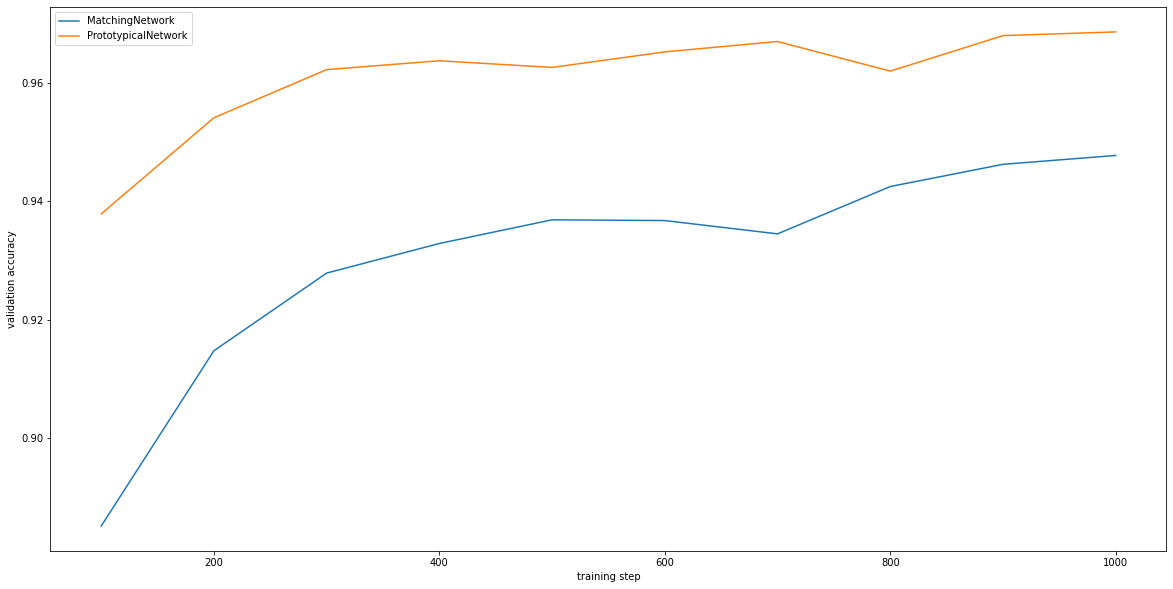

In [21]:
nets = {}
train_steps = 1000 # change as needed
plt.figure(figsize=(20, 10))
for Net in MatchingNetwork, PrototypicalNetwork:
    print(Net.__name__)
    nets[Net], train_accs, val_accs = train(Net(), train_steps)
    plt.plot((1 + np.arange(len(val_accs))) * 100, val_accs, label=Net.__name__)
plt.xlabel('training step')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

# Testing

## Mixing Alphabets for Each Task
Evaluate your trained networks on the test metadataset and fill out the table for the losses and accuracies of the the methods.

In [22]:
import pandas as pd
results = pd.DataFrame(columns=['Test Accuracy', 'Test Loss'])
for Net, net in nets.items():
    loss, accuracy = metrics = evaluate(net, test_metadataset)
    results.loc[Net.__name__] = [accuracy, loss]
pd.DataFrame(results).applymap(lambda x: '%.5g' % x)

,Test Accuracy,Test Loss
MatchingNetwork,0.962,1.032
PrototypicalNetwork,0.97588,0.068815


## Single Alphabet for Each Task
Above we still used `MixAlphabetsDataLoader` at testing time, mixing all the alphabets together before sampling. This is similar to how the papers themselves evaluate the models, but it doesn't really make sense for applying the one-shot technique to classify characters _within_ a language. Let's investigate how the test results changes on the test alphabets if we only sample WITHIN an alphabet for each task.

Note: The code for this has been implemented for you. You only need to write about your observations.

In [23]:
class SingleAlphabetsTaskLoader:
    def __init__(self, alphabets, batch_size):
        """
        alphabets: a dictionary mapping from alphabet names to arrays of size (num_characters, num_writers, H, W),
            where num_characters is the number of characters in the alphabet
        batch_size: number of tasks to generate at once
        """
        self.batch_size = batch_size
        self.alphabets = alphabets # Dictionary mapping name to shape (num_class, num_writers, H, W) array
    
    def __iter__(self):
        """
        This class is an iterable that yields a batch of tasks at each iteration when used in a for-loop.
        Each task in the batch has N_way classes (characters) randomly sampled from a single alphabet in
        the meta-dataset. Each class has K_shot + Q_queryperclass images; the first K_shot images are 
        the support set and the last Q_queryperclass images are the queries

        return: a batch of tasks, which should be a numpy array shaped
            (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        """
        alphabet_names = list(self.alphabets.keys())
        while True:
            batch = []
            for _ in range(self.batch_size):
                # Randomly sample an alphabet, then sample N_way classes from this alphabet's characters
                alphabet_name = np.random.choice(alphabet_names)
                alphabet = self.alphabets[alphabet_name]

                num_class = len(alphabet)
                classes = np.random.choice(num_class, size=N_way, replace=False)

                supports_queries = [] # Shape (K_shot + Q_queryperclass, H, W)
                for cls in classes:
                    idxs = np.random.choice(num_writers, size=K_shot + Q_queryperclass, replace=False)
                    supports_queries.append(alphabet[cls, idxs])
                batch.append(supports_queries)
                
            yield np.array(batch) # Shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)

In [24]:
single_alphabet_test_metadataset = SingleAlphabetsTaskLoader(test_alphabets, 1600)

In [25]:
# Evaluate the trained networks on the single_alphabet_test_metadataset
import pandas as pd
results = pd.DataFrame(columns=['Test Accuracy', 'Test Loss'])
for Net, net in nets.items():
    loss, accuracy = metrics = evaluate(net, single_alphabet_test_metadataset)
    results.loc[Net.__name__] = [accuracy, loss]
pd.DataFrame(results).applymap(lambda x: '%.5g' % x)

,Test Accuracy,Test Loss
MatchingNetwork,0.9095,1.1659
PrototypicalNetwork,0.928,0.20423


What do you notice about the performance? Is it different from the mixed alphabet case? Why?

####### Your Answer here #######

According to the results displayed above, we could find that compared with those in the mixed alphabet case, the accuracy levels of both matching network and prototypical network decrease significantly in the single alphabet case, and the test accuracy of the matching network drops even more dramatically. One probable reason of this phenomenon is that as the characters in one single alphabet, rather than mixed alphabet, tend to have similar shapes, strokes, and layouts, and thus these two distance-oriented networks fail to detect the relatively modest variance among these characters and then recognize them correctly.

## Full Single Alphabet for Each Task
Let's also try to extend our 5-way ($N = 5$) trained model directly to classify each full alphabet: for each of the 13 alphabet $A_i$ in the test alphabets, let's sample $100$ batches where $N_i = |A_i|$ and evaluate the performance of our model. We moved the models to CPU to avoid running out of GPU memory (it shouldn't take toooo long).

Note: The code for this has been implemented for you. You only need to write about your observations.

In [26]:
class FullAlphabetTaskLoader:
    def __init__(self, alphabet, batch_size):
        """
        Here the alphabet is just a single alphabet. 

        alphabet: an array of size (num_characters, num_writers, H, W),
            where num_characters is the number of characters in the alphabet
        batch_size: number of tasks to generate at once
        """
        self.batch_size = batch_size
        self.alphabet = alphabet # Shape (num_class, num_writers, H, W) numpy array
    
    def __iter__(self):
        """
        This class is an iterable that yields a batch of tasks at each iteration when used in a for-loop.
        Each task in the batch has N_way equal to the number of characters in the given alphabet. 
        Each class has K_shot + Q_queryperclass images; the first K_shot images are 
        the support set and the last Q_queryperclass images are the queries

        return: a batch of tasks, which should be a numpy array shaped
            (batch_size, N_way, K_shot + Q_queryperclass, H, W)
        """
        while True:
            batch = []
            for _ in range(self.batch_size):
                num_class = len(self.alphabet)
                classes = np.arange(num_class)

                supports_queries = [] # shape (K_shot + Q_queryperclass, H, W)
                for cls in classes:
                    idxs = np.random.choice(num_writers, size=K_shot + Q_queryperclass, replace=False)
                    supports_queries.append(alphabet[cls, idxs])
                batch.append(supports_queries)
                
                batch.append(supports_queries)
                
            yield np.array(batch) # shape (batch_size, N_way, K_shot + Q_queryperclass, H, W)

Alphabet N_Ko: N_way = 33


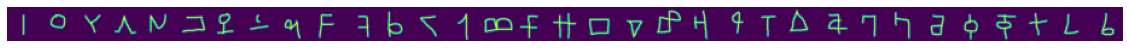

,Test Accuracy,Test Loss
MatchingNetwork,0.93303,0.2196
PrototypicalNetwork,0.93515,0.21678


Alphabet Bengali: N_way = 46


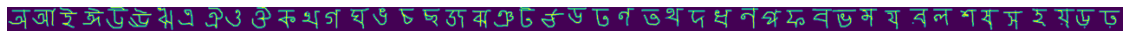

,Test Accuracy,Test Loss
MatchingNetwork,0.64,1.1868
PrototypicalNetwork,0.65957,1.1356


Alphabet Mkhedruli_(Georgian): N_way = 41


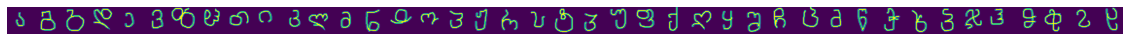

,Test Accuracy,Test Loss
MatchingNetwork,0.71171,0.96864
PrototypicalNetwork,0.70073,0.97862


Alphabet Glagolitic: N_way = 45


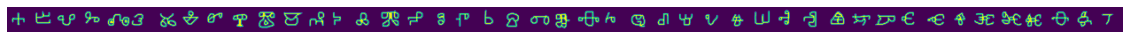

,Test Accuracy,Test Loss
MatchingNetwork,0.73533,0.91078
PrototypicalNetwork,0.73156,0.91802


Alphabet Latin: N_way = 26


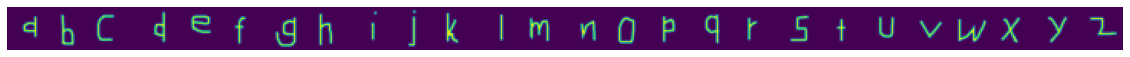

,Test Accuracy,Test Loss
MatchingNetwork,0.83423,0.515
PrototypicalNetwork,0.83654,0.50491


Alphabet Japanese_(katakana): N_way = 47


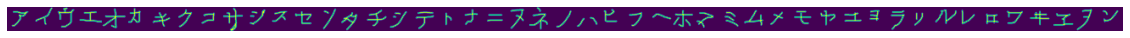

,Test Accuracy,Test Loss
MatchingNetwork,0.66255,1.1656
PrototypicalNetwork,0.66319,1.1737


Alphabet Burmese_(Myanmar): N_way = 34


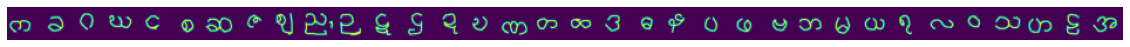

,Test Accuracy,Test Loss
MatchingNetwork,0.82676,0.56137
PrototypicalNetwork,0.82029,0.55491


Alphabet Keble: N_way = 26


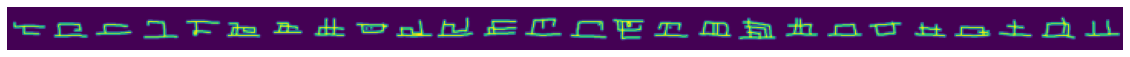

,Test Accuracy,Test Loss
MatchingNetwork,0.84808,0.50254
PrototypicalNetwork,0.845,0.482


Alphabet Syriac_(Serto): N_way = 23


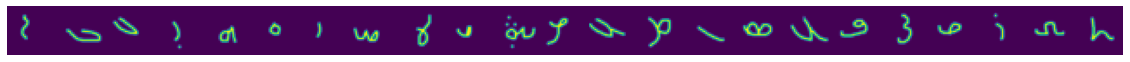

,Test Accuracy,Test Loss
MatchingNetwork,0.67957,1.0995
PrototypicalNetwork,0.69391,1.076


Alphabet Armenian: N_way = 41


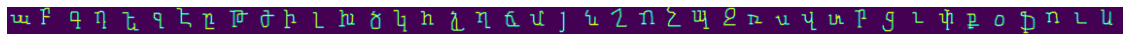

,Test Accuracy,Test Loss
MatchingNetwork,0.59976,1.5096
PrototypicalNetwork,0.59415,1.4983


Alphabet Alphabet_of_the_Magi: N_way = 20


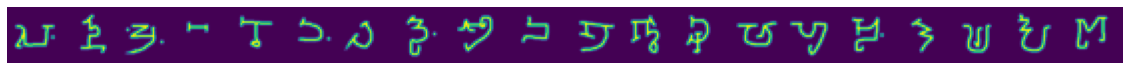

,Test Accuracy,Test Loss
MatchingNetwork,0.8145,0.60685
PrototypicalNetwork,0.8115,0.61956


Alphabet Tengwar: N_way = 25


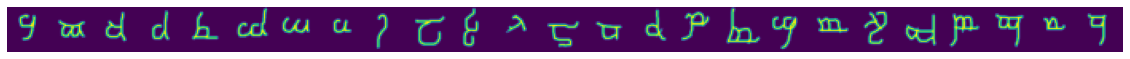

,Test Accuracy,Test Loss
MatchingNetwork,0.628,1.2464
PrototypicalNetwork,0.6344,1.198


Alphabet Oriya: N_way = 46


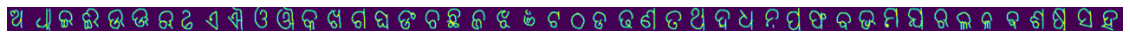

,Test Accuracy,Test Loss
MatchingNetwork,0.51935,1.6609
PrototypicalNetwork,0.53196,1.6295


In [27]:
# Evaluate the trained networks on each full alphabet

import pandas as pd
from IPython.display import display

device = 'cpu'
net_cpu = net.cpu()
for name, alphabet in test_alphabets.items():
    full_alphabet_test_metadataset = FullAlphabetTaskLoader(alphabet, 100)

    N_way = len(alphabet)
    print(f'Alphabet {name}: N_way = {N_way}')
    
    plt.figure(figsize=(20, 5))
    plt.imshow(np.concatenate(alphabet[:, 0], axis=1))
    plt.axis('off')
    plt.show()
    
    results = pd.DataFrame(columns=['Test Accuracy', 'Test Loss'])
    for Net, net in nets.items():
        loss, accuracy = metrics = evaluate(net_cpu, full_alphabet_test_metadataset)
        results.loc[Net.__name__] = [accuracy, loss]
    display(pd.DataFrame(results).applymap(lambda x: '%.5g' % x))
device = 'cuda'

What do you notice about the performances on the alphabets? Does it seem different than the Single Alphabet for Each Task cases above? Why?

####### Your Answer here #######

The performances of matching network and prototypical network are both poorer in this case compared with the single alphabet case. In general, the alphabets that have obviously distinguishable layouts (latin, N, and keble) tend to enjoy better performances, while the ones have simpler structures or similar layouts between characters (such as oriya or Syriac) bear poorer accuracies. One probable reason accounting for this phenomenon may be that, in these distance-centered models, distinguishable layouts of characters could boost the variance among characters and then improve the identification. On the other hand, simple structures (for instance, some letters in syriac is overly simple) or similar layouts (most oriya's letters are mutations on a circle), could undermine the variance among letters and hence undermine the performaces of models.